# Extraction of Watson Assistant Logs from Workspace

####  Author Omar Megawer
2018-Mar-09

In [4]:
!pip install pixiedust

  Using cached geojson-2.3.0-py2.py3-none-any.whl
  Using cached astunparse-1.5.0-py2.py3-none-any.whl
  Using cached Markdown-2.6.11-py2.py3-none-any.whl
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd
from watson_developer_cloud import ConversationV1
import numpy as np
from sklearn.model_selection import KFold
import pixiedust
import json
from urllib.parse import urlparse, parse_qs
import itertools
import matplotlib.pyplot as plt
import datetime, dateutil.parser
import seaborn as sns
%matplotlib inline
import warnings
import openpyxl
warnings.filterwarnings("ignore")

Pixiedust database opened successfully


##### Add the Watson Conversation credentials

In [3]:
ctx = {
  "url": "https://gateway.watsonplatform.net/conversation/api",
  "username": "",
  "password": ""
}

workspace_id = ""


##### Logs Extraction

In [4]:
conversation = ConversationV1( username=ctx.get('username'), password=ctx.get('password'), version='2018-02-18', url=ctx.get('url'))

extractedLogs = []
response1 = { 'pagination': 'DUMMY' } #This is set to start the loop
cursor = None
counter = 0
fltr = None  # Can be used to get a specific date

while response1['pagination']:
    print ("Reading Logs for Page: ", counter)
    counter = counter + 1
    response1 = conversation.list_logs(workspace_id=workspace_id, page_limit = 1000, cursor=cursor)
    extractedLogs.append(response1['logs'])
    
    #The API has a limit of a 100 logs to pull
    #To get the full log You need to update the cursor variable with a new cursor pointing to the next page
    #The cursor is fetched using the next_url variable
    
    if 'pagination' in response1 and 'next_url' in response1['pagination']:
        p = response1['pagination']['next_url']
        u = urlparse(p) 
        query = parse_qs(u.query)
        cursor = query['cursor'][0]

Reading Logs for Page:  0
Reading Logs for Page:  1


##### Formatting the logs into a Dataframe
The only needed fields are Conversation ID, Timestamp, Input, Output,  Confidence Level and Intent Detected

In [ ]:
extraction = []
for logs in extractedLogs:
    for elem in logs:
        userinput = elem['response']['input']
        logID = elem['response']['context']['conversation_id']
        if not elem['response']['intents']:
            intentss = [{'confidence': 0, 'intent': 'No Intent Detected'}]
            intentss = intentss[0]
        else:
            intentss = elem['response']['intents'][0]
        
    
        wcsoutput = elem['response']['output']
        userInput = userinput.get('text')
        wcsOutput = wcsoutput.get('text')
        time = elem['request_timestamp']
        row = {
            'Log_ID': logID,
            'Request_TimeStamp': dateutil.parser.parse(time).strftime('%d/%m/%Y'),
            'User_Input': userInput,
            'Watson_Output': wcsOutput,
            'Confidence_Level': intentss['confidence'] * 100,
            'Intent_Detected': intentss['intent']
        }
        extraction.append(row)
df = pd.DataFrame(extraction, columns=['Log_ID', 'User_Input', 'Intent_Detected','Confidence_Level','Watson_Output', 'Request_TimeStamp'])
display(df)

Log_ID,User_Input,Intent_Detected,Confidence_Level,Watson_Output,Request_TimeStamp
bb468e34-a777-4017-8318-697cce3ba981,None,No Intent Detected,0.0,['Hello. How can I help you?'],01/05/2018
bb468e34-a777-4017-8318-697cce3ba981,asdasdasd,General_Positive_Feedback,12.650503158569334,['[YOUR INTRODUCTION OF THE TEXT] : '],01/05/2018
1da55290-e50e-43fd-9c5b-2c44c92dc13f,asdasdasd,General_Positive_Feedback,12.650503158569334,['[YOUR INTRODUCTION OF THE TEXT] : '],01/05/2018
cc6cb290-ab39-4aed-9488-70614e869e83,asdasdasd,General_Positive_Feedback,12.650503158569334,['[YOUR INTRODUCTION OF THE TEXT] : '],01/05/2018
9fd36559-125f-41c0-807c-7c09fd671df3,None,No Intent Detected,0.0,['Hello. How can I help you?'],01/05/2018
9fd36559-125f-41c0-807c-7c09fd671df3,asdasdasd,General_Positive_Feedback,12.650503158569334,['[YOUR INTRODUCTION OF THE TEXT] : '],01/05/2018
7a8ecaab-d7ab-41c2-a908-7f5ac4f946e2,sdadasdad,General_Positive_Feedback,11.268861293792726,['[YOUR INTRODUCTION OF THE TEXT] : '],01/05/2018
e7c4c342-e9ca-411a-ac52-567f185aa063,None,No Intent Detected,0.0,['Hello. How can I help you?'],01/05/2018
e7c4c342-e9ca-411a-ac52-567f185aa063,Ahmed,General_Greetings,14.485103607177738,['[YOUR INTRODUCTION OF THE TEXT] : '],01/05/2018
003bf730-a360-493b-9573-33c8ca3feb24,this is really annoying,General_Negative_Feedback,97.31963157653809,"['Checking Tone', ""sorry I didn't understand""]",02/05/2018


##### Save Logs as Excel

In [6]:
writer = pd.ExcelWriter('Logs.xlsx')
df.to_excel(writer, "Extracted Logs")
writer.save()

---

##### Number of Conversations

In [7]:
uniqueConversations = df.Log_ID.nunique() 
print("Number of Conversations in the Log: ", uniqueConversations)

Number of Conversations in the Log:  37


---

##### Conversations Per Day

In [ ]:
convPerDay = df.groupby(['Request_TimeStamp'], as_index=False).count()
convPerDay = convPerDay.drop(['User_Input', 'Intent_Detected','Confidence_Level','Watson_Output'], axis=1)
convPerDay = convPerDay.sort_values('Request_TimeStamp')
convPerDay.columns=['Date', 'Conversation Count']
display(convPerDay)

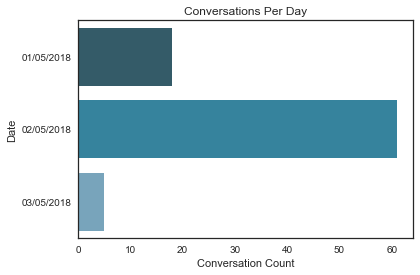

In [9]:
sns.set(style="white", context="notebook")
vis1 = sns.barplot(x = 'Conversation Count', y = 'Date', data = convPerDay, palette="PuBuGn_d").set_title('Conversations Per Day')
plt.savefig('ConversationsPerDay.png', bbox_inches='tight')

---

##### Intent Frequency

In [10]:
intentCount = df.groupby(['Intent_Detected'], as_index=False).count()
intentCount = intentCount.drop(['User_Input', 'Request_TimeStamp','Confidence_Level','Watson_Output'], axis=1)
intentCount.columns =  ['Intent', 'Count']
intentCount = intentCount.sort_values('Count', ascending=False)
intentCount = intentCount[intentCount.Intent != 'No Intent Detected'] # Removing the intents that were not matched

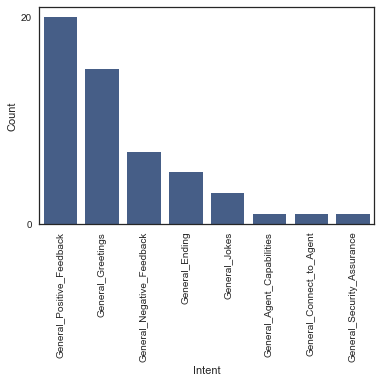

In [11]:
plt.xticks(rotation = 90)

sns.set(rc={'figure.figsize':(50,50)}, font_scale=6, style = 'white')

vis2 = sns.barplot(x = 'Intent' , y = 'Count', data = intentCount, color = "#3b5b92")

plt.savefig('IntentFreq.png', bbox_inches='tight')

---

##### Intents with Low Confidence

In [12]:
lowConf = df[df.Confidence_Level < 40]
lowConf.to_excel(writer, "Low Confidence")
writer.save()

---